In [1]:
import sys
sys.path.append("..")

from utility_functions import *
from ensemble_functions import *

import random
from random import seed 
import glob
import os

import pandas as pd
import numpy as np

from openbabel import openbabel

import sklearn.metrics
from sklearn.metrics import roc_curve, auc, make_scorer, confusion_matrix
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import tree

from IPython.display import Image

import pydotplus

from matplotlib import pyplot as plt

import oddt
from oddt.fingerprints import InteractionFingerprint, PLEC, SPLIF, ECFP

from joblib import dump, load

%matplotlib inline

In [2]:
pattern_agonist = ["[0-9]_full_agonist", "[0-9]_agonist"]
pattern_antagonist = ["antagonist"]

In [3]:
6A93_P28223_proc_cleaned.pdbqt
6LUQ_P14416_proc_cleaned.pdbqt
6CM4_P14416_proc_cleaned.pdbqt

SyntaxError: invalid syntax (<ipython-input-3-e0038e3c07fb>, line 1)

In [32]:
file_agonist = [file for p in pattern_agonist for file in glob.glob("../DATAS/Ligands/6LUQ*"+p+"*best.sdf")]
file_antagonist = [file for p in pattern_antagonist for file in glob.glob("../DATAS/Ligands/6LUQ*"+p+"*best.sdf")]

In [33]:
# Save the image of each agonist
agonist_poses_tmp = []
for file in file_agonist:
    agonist_poses_tmp.append(list(oddt.toolkit.readfile("sdf", "{}".format(file))))
    
# Save the image of each antagonist
antagonist_poses_tmp = []
for file in file_antagonist:
    antagonist_poses_tmp.append(list(oddt.toolkit.readfile('sdf', '{}'.format(file))))
    
# Create a duplicate of each list
antagonist_poses = [x[:] for x in antagonist_poses_tmp]
agonist_poses = [x[:] for x in agonist_poses_tmp]

In [34]:
# read the protein
protein = next(oddt.toolkit.readfile('pdbqt', '../DATAS/6LUQ_P14416_proc_cleaned.pdbqt'))
protein.protein = True

In [35]:
# list of fingerprint for all agonist_poses best protein_depth=5 ligand_depth=1 size=65536
IFP_list_agonists = np.array([PLEC(x[0], protein, sparse=False) for x in agonist_poses])
# list of fingerprint for all antagonist_poses
IFP_list_antagonists = np.array([PLEC(x[0], protein, sparse=False) for x in antagonist_poses])

In [36]:
#add 1 if class antagonist
antagonist_with_active = []
for subarray in IFP_list_antagonists:
    antagonist_with_active.append(np.append([subarray],[1]))
#add 0 if class agonist
agonist_with_active = []
for subarray in IFP_list_agonists:
    agonist_with_active.append(np.append([subarray],[0]))

In [37]:
# put all agonist and antagonist inside data
data = []
for e in agonist_with_active:
    data.append(e)
for e in antagonist_with_active:
    data.append(e)

In [38]:
FEATURES = np.array([data[i][:-1:] for i in range(len(data))])
LABELS = np.array([data[i][-1] for i in range(len(data))])

In [39]:
len(FEATURES[0])

16384

In [40]:
FEATURES[0].shape

(16384,)

In [41]:
no_event_train, no_event_test, no_event_labels_train, no_event_labels_test = train_test_split(FEATURES[LABELS == 0], 
                                                                                    LABELS[LABELS == 0], 
                                                                                    test_size=0.5, 
                                                                                    random_state=0)
event_train, event_test, event_labels_train, event_labels_test = train_test_split(FEATURES[LABELS == 1],
                                                                              LABELS[LABELS == 1], 
                                                                              test_size=0.5, 
                                                                              random_state=0)
#pre processing of TRAIN and TEST
TRAIN_tmp = np.concatenate((no_event_train,event_train))
TEST_tmp = np.concatenate((no_event_test,event_test))
TRAIN_LABELS_tmp = np.concatenate((no_event_labels_train,event_labels_train))
TEST_LABELS_tmp = np.concatenate((no_event_labels_test,event_labels_test))

#TRAIN AND TEST LISTS
TRAIN, TRAIN_LABELS = shuffle(TRAIN_tmp, TRAIN_LABELS_tmp)
TEST, TEST_LABELS = shuffle(TEST_tmp, TEST_LABELS_tmp)

In [42]:
def f1_score(y_true, y_pred):
    """
    f1 score

    :param y_true:
    :param y_pred:
    :return:
    """
    tp_3d = K.concatenate(
        [
            K.cast(y_true, 'bool'),
            K.cast(K.round(y_pred), 'bool'),
            K.cast(K.ones_like(y_pred), 'bool')
        ], axis=1
    )

    fp_3d = K.concatenate(
        [
            K.cast(K.abs(y_true - K.ones_like(y_true)), 'bool'),
            K.cast(K.round(y_pred), 'bool'),
            K.cast(K.ones_like(y_pred), 'bool')
        ], axis=1
    )

    fn_3d = K.concatenate(
        [
            K.cast(y_true, 'bool'),
            K.cast(K.abs(K.round(y_pred) - K.ones_like(y_pred)), 'bool'),
            K.cast(K.ones_like(y_pred), 'bool')
        ], axis=1
    )

    tp = K.sum(K.cast(K.all(tp_3d, axis=1), 'int32'))
    fp = K.sum(K.cast(K.all(fp_3d, axis=1), 'int32'))
    fn = K.sum(K.cast(K.all(fn_3d, axis=1), 'int32'))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return 2 * ((precision * recall) / (precision + recall))

In [43]:
def mcc_metric(y_true, y_pred):
  predicted = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
  true_pos = tf.math.count_nonzero(predicted * y_true)
  true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
  false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
  false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
  x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
      * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
  return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

### Creation network

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, models, utils
import keras.backend as K

In [45]:
tf.keras.backend.clear_session()

x_in = Input(shape=FEATURES[0].shape)
x = layers.Dense(15, activation=tf.nn.relu)(x_in)
x = layers.Dense(15, activation=tf.nn.relu)(x)
x = layers.Dense(15, activation=tf.nn.relu)(x)
x = layers.Dense(15, activation=tf.nn.relu)(x)
x_out = layers.Dense(1, activation=tf.nn.sigmoid)(x)
model = Model(inputs=x_in, outputs=x_out)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16384)]           0         
_________________________________________________________________
dense (Dense)                (None, 15)                245775    
_________________________________________________________________
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_3 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 16        
Total params: 246,511
Trainable params: 246,511
Non-trainable params: 0
________________________________________________

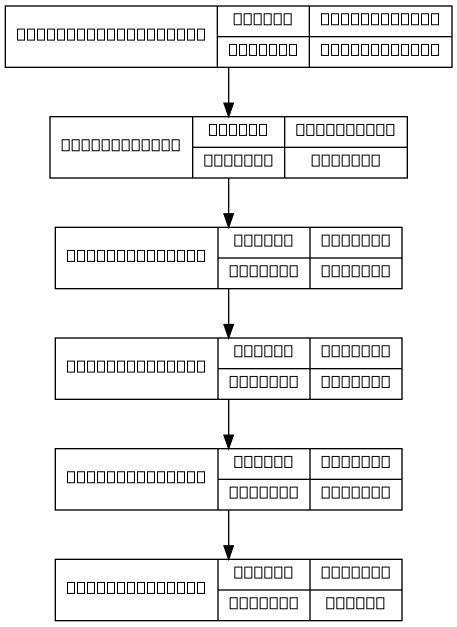

In [46]:
from tensorflow.keras.utils import plot_model
plot_model(model, "output_model.png", show_shapes=True)


In [47]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=[f1_score, mcc_metric, "accuracy"])

In [48]:
history = model.fit(TRAIN, TRAIN_LABELS, epochs=10000, batch_size=32, verbose=2)

Epoch 1/10000
1/1 - 0s - loss: 0.6748 - f1_score: 0.8302 - mcc_metric: 0.2664 - accuracy: 0.7188
Epoch 2/10000
1/1 - 0s - loss: 0.6369 - f1_score: 0.8148 - mcc_metric: nan - accuracy: 0.6875
Epoch 3/10000
1/1 - 0s - loss: 0.6101 - f1_score: 0.8462 - mcc_metric: 0.3830 - accuracy: 0.7500
Epoch 4/10000
1/1 - 0s - loss: 0.5883 - f1_score: 0.8627 - mcc_metric: 0.4771 - accuracy: 0.7812
Epoch 5/10000
1/1 - 0s - loss: 0.5702 - f1_score: 0.8980 - mcc_metric: 0.6383 - accuracy: 0.8438
Epoch 6/10000
1/1 - 0s - loss: 0.5533 - f1_score: 0.8980 - mcc_metric: 0.6383 - accuracy: 0.8438
Epoch 7/10000
1/1 - 0s - loss: 0.5369 - f1_score: 0.8980 - mcc_metric: 0.6383 - accuracy: 0.8438
Epoch 8/10000
1/1 - 0s - loss: 0.5234 - f1_score: 0.8980 - mcc_metric: 0.6383 - accuracy: 0.8438
Epoch 9/10000
1/1 - 0s - loss: 0.5093 - f1_score: 0.8980 - mcc_metric: 0.6383 - accuracy: 0.8438
Epoch 10/10000
1/1 - 0s - loss: 0.4977 - f1_score: 0.8980 - mcc_metric: 0.6383 - accuracy: 0.8438
Epoch 11/10000
1/1 - 0s - loss: 

Epoch 85/10000
1/1 - 0s - loss: 0.1769 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 86/10000
1/1 - 0s - loss: 0.1764 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 87/10000
1/1 - 0s - loss: 0.1739 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 88/10000
1/1 - 0s - loss: 0.1719 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 89/10000
1/1 - 0s - loss: 0.1700 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 90/10000
1/1 - 0s - loss: 0.1683 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 91/10000
1/1 - 0s - loss: 0.1671 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 92/10000
1/1 - 0s - loss: 0.1660 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 93/10000
1/1 - 0s - loss: 0.1640 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 94/10000
1/1 - 0s - loss: 0.1625 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 95/10000
1/1 -

Epoch 168/10000
1/1 - 0s - loss: 0.0716 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 169/10000
1/1 - 0s - loss: 0.0709 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 170/10000
1/1 - 0s - loss: 0.0698 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 171/10000
1/1 - 0s - loss: 0.0686 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 172/10000
1/1 - 0s - loss: 0.0678 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 173/10000
1/1 - 0s - loss: 0.0668 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 174/10000
1/1 - 0s - loss: 0.0660 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 175/10000
1/1 - 0s - loss: 0.0652 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 176/10000
1/1 - 0s - loss: 0.0641 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 177/10000
1/1 - 0s - loss: 0.0634 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 178/

Epoch 251/10000
1/1 - 0s - loss: 0.0233 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 252/10000
1/1 - 0s - loss: 0.0229 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 253/10000
1/1 - 0s - loss: 0.0227 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 254/10000
1/1 - 0s - loss: 0.0224 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 255/10000
1/1 - 0s - loss: 0.0223 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 256/10000
1/1 - 0s - loss: 0.0218 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 257/10000
1/1 - 0s - loss: 0.0216 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 258/10000
1/1 - 0s - loss: 0.0215 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 259/10000
1/1 - 0s - loss: 0.0211 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 260/10000
1/1 - 0s - loss: 0.0209 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 261/

Epoch 334/10000
1/1 - 0s - loss: 0.0098 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 335/10000
1/1 - 0s - loss: 0.0097 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 336/10000
1/1 - 0s - loss: 0.0096 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 337/10000
1/1 - 0s - loss: 0.0095 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 338/10000
1/1 - 0s - loss: 0.0094 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 339/10000
1/1 - 0s - loss: 0.0093 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 340/10000
1/1 - 0s - loss: 0.0092 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 341/10000
1/1 - 0s - loss: 0.0092 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 342/10000
1/1 - 0s - loss: 0.0090 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 343/10000
1/1 - 0s - loss: 0.0090 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 344/

Epoch 417/10000
1/1 - 0s - loss: 0.0036 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 418/10000
1/1 - 0s - loss: 0.0036 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 419/10000
1/1 - 0s - loss: 0.0035 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 420/10000
1/1 - 0s - loss: 0.0035 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 421/10000
1/1 - 0s - loss: 0.0034 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 422/10000
1/1 - 0s - loss: 0.0034 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 423/10000
1/1 - 0s - loss: 0.0033 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 424/10000
1/1 - 0s - loss: 0.0033 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 425/10000
1/1 - 0s - loss: 0.0032 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 426/10000
1/1 - 0s - loss: 0.0032 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 427/

Epoch 500/10000
1/1 - 0s - loss: 8.1732e-04 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 501/10000
1/1 - 0s - loss: 8.0405e-04 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 502/10000
1/1 - 0s - loss: 7.8293e-04 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 503/10000
1/1 - 0s - loss: 7.6909e-04 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 504/10000
1/1 - 0s - loss: 7.4777e-04 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 505/10000
1/1 - 0s - loss: 7.3549e-04 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 506/10000
1/1 - 0s - loss: 7.1739e-04 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 507/10000
1/1 - 0s - loss: 7.0713e-04 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 508/10000
1/1 - 0s - loss: 6.8612e-04 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 509/10000
1/1 - 0s - loss: 6.7586e-04 - f1_score: 1.0000 - mcc_metr

Epoch 580/10000
1/1 - 0s - loss: 9.5426e-05 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 581/10000
1/1 - 0s - loss: 9.2571e-05 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 582/10000
1/1 - 0s - loss: 8.9520e-05 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 583/10000
1/1 - 0s - loss: 8.7226e-05 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 584/10000
1/1 - 0s - loss: 8.4025e-05 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 585/10000
1/1 - 0s - loss: 8.1534e-05 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 586/10000
1/1 - 0s - loss: 7.8935e-05 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 587/10000
1/1 - 0s - loss: 7.6472e-05 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 588/10000
1/1 - 0s - loss: 7.4486e-05 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 589/10000
1/1 - 0s - loss: 7.1735e-05 - f1_score: 1.0000 - mcc_metr

Epoch 660/10000
1/1 - 0s - loss: 7.7020e-06 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 661/10000
1/1 - 0s - loss: 7.4080e-06 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 662/10000
1/1 - 0s - loss: 7.1390e-06 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 663/10000
1/1 - 0s - loss: 6.9606e-06 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 664/10000
1/1 - 0s - loss: 6.7219e-06 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 665/10000
1/1 - 0s - loss: 6.5115e-06 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 666/10000
1/1 - 0s - loss: 6.3385e-06 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 667/10000
1/1 - 0s - loss: 6.0774e-06 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 668/10000
1/1 - 0s - loss: 5.8933e-06 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 669/10000
1/1 - 0s - loss: 5.6889e-06 - f1_score: 1.0000 - mcc_metr

Epoch 740/10000
1/1 - 0s - loss: 5.6246e-07 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 741/10000
1/1 - 0s - loss: 5.4567e-07 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 742/10000
1/1 - 0s - loss: 5.2798e-07 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 743/10000
1/1 - 0s - loss: 5.1323e-07 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 744/10000
1/1 - 0s - loss: 4.9710e-07 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 745/10000
1/1 - 0s - loss: 4.8295e-07 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 746/10000
1/1 - 0s - loss: 4.6765e-07 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 747/10000
1/1 - 0s - loss: 4.5490e-07 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 748/10000
1/1 - 0s - loss: 4.3991e-07 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 749/10000
1/1 - 0s - loss: 4.2822e-07 - f1_score: 1.0000 - mcc_metr

Epoch 820/10000
1/1 - 0s - loss: 7.3823e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 821/10000
1/1 - 0s - loss: 7.2355e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 822/10000
1/1 - 0s - loss: 7.1161e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 823/10000
1/1 - 0s - loss: 6.9794e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 824/10000
1/1 - 0s - loss: 6.8446e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 825/10000
1/1 - 0s - loss: 6.7253e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 826/10000
1/1 - 0s - loss: 6.5992e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 827/10000
1/1 - 0s - loss: 6.4962e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 828/10000
1/1 - 0s - loss: 6.3646e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 829/10000
1/1 - 0s - loss: 6.2565e-08 - f1_score: 1.0000 - mcc_metr

Epoch 900/10000
1/1 - 0s - loss: 2.4412e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 901/10000
1/1 - 0s - loss: 2.4167e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 902/10000
1/1 - 0s - loss: 2.3934e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 903/10000
1/1 - 0s - loss: 2.3746e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 904/10000
1/1 - 0s - loss: 2.3496e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 905/10000
1/1 - 0s - loss: 2.3260e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 906/10000
1/1 - 0s - loss: 2.3030e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 907/10000
1/1 - 0s - loss: 2.2811e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 908/10000
1/1 - 0s - loss: 2.2604e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 909/10000
1/1 - 0s - loss: 2.2392e-08 - f1_score: 1.0000 - mcc_metr

Epoch 980/10000
1/1 - 0s - loss: 1.3819e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 981/10000
1/1 - 0s - loss: 1.3749e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 982/10000
1/1 - 0s - loss: 1.3682e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 983/10000
1/1 - 0s - loss: 1.3624e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 984/10000
1/1 - 0s - loss: 1.3503e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 985/10000
1/1 - 0s - loss: 1.3453e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 986/10000
1/1 - 0s - loss: 1.3385e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 987/10000
1/1 - 0s - loss: 1.3341e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 988/10000
1/1 - 0s - loss: 1.3269e-08 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 989/10000
1/1 - 0s - loss: 1.3211e-08 - f1_score: 1.0000 - mcc_metr

Epoch 1059/10000
1/1 - 0s - loss: 9.9430e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1060/10000
1/1 - 0s - loss: 9.9558e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1061/10000
1/1 - 0s - loss: 9.9557e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1062/10000
1/1 - 0s - loss: 9.9057e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1063/10000
1/1 - 0s - loss: 9.9084e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1064/10000
1/1 - 0s - loss: 9.9087e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1065/10000
1/1 - 0s - loss: 9.7986e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1066/10000
1/1 - 0s - loss: 9.8071e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1067/10000
1/1 - 0s - loss: 9.8095e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1068/10000
1/1 - 0s - loss: 9.7672e-09 - f1_score: 1.0000 

Epoch 1138/10000
1/1 - 0s - loss: 8.6240e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1139/10000
1/1 - 0s - loss: 8.6352e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1140/10000
1/1 - 0s - loss: 8.6471e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1141/10000
1/1 - 0s - loss: 8.5256e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1142/10000
1/1 - 0s - loss: 8.5434e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1143/10000
1/1 - 0s - loss: 8.5539e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1144/10000
1/1 - 0s - loss: 8.5663e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1145/10000
1/1 - 0s - loss: 8.5759e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1146/10000
1/1 - 0s - loss: 8.5208e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1147/10000
1/1 - 0s - loss: 8.5329e-09 - f1_score: 1.0000 

Epoch 1217/10000
1/1 - 0s - loss: 7.9408e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1218/10000
1/1 - 0s - loss: 7.8795e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1219/10000
1/1 - 0s - loss: 7.8938e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1220/10000
1/1 - 0s - loss: 7.9077e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1221/10000
1/1 - 0s - loss: 7.9211e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1222/10000
1/1 - 0s - loss: 7.8611e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1223/10000
1/1 - 0s - loss: 7.8741e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1224/10000
1/1 - 0s - loss: 7.8865e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1225/10000
1/1 - 0s - loss: 7.9002e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1226/10000
1/1 - 0s - loss: 7.9120e-09 - f1_score: 1.0000 

Epoch 1296/10000
1/1 - 0s - loss: 7.4691e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1297/10000
1/1 - 0s - loss: 7.4882e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1298/10000
1/1 - 0s - loss: 7.5010e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1299/10000
1/1 - 0s - loss: 7.5135e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1300/10000
1/1 - 0s - loss: 7.5259e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1301/10000
1/1 - 0s - loss: 7.5378e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1302/10000
1/1 - 0s - loss: 7.4016e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1303/10000
1/1 - 0s - loss: 7.4190e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1304/10000
1/1 - 0s - loss: 7.4333e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1305/10000
1/1 - 0s - loss: 7.4462e-09 - f1_score: 1.0000 

Epoch 1375/10000
1/1 - 0s - loss: 7.2860e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1376/10000
1/1 - 0s - loss: 7.2987e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1377/10000
1/1 - 0s - loss: 7.2290e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1378/10000
1/1 - 0s - loss: 7.2428e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1379/10000
1/1 - 0s - loss: 7.2543e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1380/10000
1/1 - 0s - loss: 7.2665e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1381/10000
1/1 - 0s - loss: 7.2783e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1382/10000
1/1 - 0s - loss: 7.2089e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1383/10000
1/1 - 0s - loss: 7.2224e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1384/10000
1/1 - 0s - loss: 7.2347e-09 - f1_score: 1.0000 

Epoch 1454/10000
1/1 - 0s - loss: 7.1414e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1455/10000
1/1 - 0s - loss: 7.0691e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1456/10000
1/1 - 0s - loss: 7.0850e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1457/10000
1/1 - 0s - loss: 7.0963e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1458/10000
1/1 - 0s - loss: 7.1075e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1459/10000
1/1 - 0s - loss: 7.0360e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1460/10000
1/1 - 0s - loss: 7.0485e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1461/10000
1/1 - 0s - loss: 7.0610e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1462/10000
1/1 - 0s - loss: 7.0730e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1463/10000
1/1 - 0s - loss: 7.0839e-09 - f1_score: 1.0000 

Epoch 1533/10000
1/1 - 0s - loss: 6.9805e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1534/10000
1/1 - 0s - loss: 6.9912e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1535/10000
1/1 - 0s - loss: 7.0024e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1536/10000
1/1 - 0s - loss: 7.0130e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1537/10000
1/1 - 0s - loss: 7.0238e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1538/10000
1/1 - 0s - loss: 7.0342e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1539/10000
1/1 - 0s - loss: 6.9559e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1540/10000
1/1 - 0s - loss: 6.9693e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1541/10000
1/1 - 0s - loss: 6.9803e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1542/10000
1/1 - 0s - loss: 6.9911e-09 - f1_score: 1.0000 

Epoch 1612/10000
1/1 - 0s - loss: 6.8914e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1613/10000
1/1 - 0s - loss: 6.9017e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1614/10000
1/1 - 0s - loss: 6.9120e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1615/10000
1/1 - 0s - loss: 6.9220e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1616/10000
1/1 - 0s - loss: 6.9321e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1617/10000
1/1 - 0s - loss: 6.9420e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1618/10000
1/1 - 0s - loss: 6.9522e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1619/10000
1/1 - 0s - loss: 6.9619e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1620/10000
1/1 - 0s - loss: 6.8900e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1621/10000
1/1 - 0s - loss: 6.9020e-09 - f1_score: 1.0000 

Epoch 1691/10000
1/1 - 0s - loss: 6.9142e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1692/10000
1/1 - 0s - loss: 6.8332e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1693/10000
1/1 - 0s - loss: 6.8441e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1694/10000
1/1 - 0s - loss: 6.8558e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1695/10000
1/1 - 0s - loss: 6.8658e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1696/10000
1/1 - 0s - loss: 6.8755e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1697/10000
1/1 - 0s - loss: 6.8851e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1698/10000
1/1 - 0s - loss: 6.8063e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1699/10000
1/1 - 0s - loss: 6.8188e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1700/10000
1/1 - 0s - loss: 6.8302e-09 - f1_score: 1.0000 

Epoch 1770/10000
1/1 - 0s - loss: 6.8588e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1771/10000
1/1 - 0s - loss: 6.7819e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1772/10000
1/1 - 0s - loss: 6.7932e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1773/10000
1/1 - 0s - loss: 6.8036e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1774/10000
1/1 - 0s - loss: 6.8129e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1775/10000
1/1 - 0s - loss: 6.8219e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1776/10000
1/1 - 0s - loss: 6.8311e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1777/10000
1/1 - 0s - loss: 6.8401e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1778/10000
1/1 - 0s - loss: 6.8493e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1779/10000
1/1 - 0s - loss: 6.8584e-09 - f1_score: 1.0000 

Epoch 1849/10000
1/1 - 0s - loss: 6.7657e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1850/10000
1/1 - 0s - loss: 6.7772e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1851/10000
1/1 - 0s - loss: 6.7876e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1852/10000
1/1 - 0s - loss: 6.7981e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1853/10000
1/1 - 0s - loss: 6.8078e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1854/10000
1/1 - 0s - loss: 6.8176e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1855/10000
1/1 - 0s - loss: 6.8274e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1856/10000
1/1 - 0s - loss: 6.8372e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1857/10000
1/1 - 0s - loss: 6.8467e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1858/10000
1/1 - 0s - loss: 6.8565e-09 - f1_score: 1.0000 

Epoch 1928/10000
1/1 - 0s - loss: 6.7984e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1929/10000
1/1 - 0s - loss: 6.8076e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1930/10000
1/1 - 0s - loss: 6.8168e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1931/10000
1/1 - 0s - loss: 6.8260e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1932/10000
1/1 - 0s - loss: 6.5771e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1933/10000
1/1 - 0s - loss: 6.5878e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1934/10000
1/1 - 0s - loss: 6.5987e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1935/10000
1/1 - 0s - loss: 6.6097e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1936/10000
1/1 - 0s - loss: 6.6208e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 1937/10000
1/1 - 0s - loss: 6.6311e-09 - f1_score: 1.0000 

Epoch 2007/10000
1/1 - 0s - loss: 6.6910e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2008/10000
1/1 - 0s - loss: 6.7006e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2009/10000
1/1 - 0s - loss: 6.7102e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2010/10000
1/1 - 0s - loss: 6.7199e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2011/10000
1/1 - 0s - loss: 6.7285e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2012/10000
1/1 - 0s - loss: 6.7372e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2013/10000
1/1 - 0s - loss: 6.7459e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2014/10000
1/1 - 0s - loss: 6.7546e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2015/10000
1/1 - 0s - loss: 6.7630e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2016/10000
1/1 - 0s - loss: 6.6483e-09 - f1_score: 1.0000 

Epoch 2086/10000
1/1 - 0s - loss: 6.6155e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2087/10000
1/1 - 0s - loss: 6.6254e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2088/10000
1/1 - 0s - loss: 6.6354e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2089/10000
1/1 - 0s - loss: 6.6454e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2090/10000
1/1 - 0s - loss: 6.6540e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2091/10000
1/1 - 0s - loss: 6.6625e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2092/10000
1/1 - 0s - loss: 6.6710e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2093/10000
1/1 - 0s - loss: 6.6793e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2094/10000
1/1 - 0s - loss: 6.6875e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2095/10000
1/1 - 0s - loss: 6.6954e-09 - f1_score: 1.0000 

Epoch 2165/10000
1/1 - 0s - loss: 6.6886e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2166/10000
1/1 - 0s - loss: 6.6957e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2167/10000
1/1 - 0s - loss: 6.7028e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2168/10000
1/1 - 0s - loss: 6.7099e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2169/10000
1/1 - 0s - loss: 6.6151e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2170/10000
1/1 - 0s - loss: 6.6236e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2171/10000
1/1 - 0s - loss: 6.6321e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2172/10000
1/1 - 0s - loss: 6.6399e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2173/10000
1/1 - 0s - loss: 6.6477e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2174/10000
1/1 - 0s - loss: 6.6552e-09 - f1_score: 1.0000 

Epoch 2244/10000
1/1 - 0s - loss: 6.6764e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2245/10000
1/1 - 0s - loss: 6.5811e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2246/10000
1/1 - 0s - loss: 6.5895e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2247/10000
1/1 - 0s - loss: 6.5974e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2248/10000
1/1 - 0s - loss: 6.6056e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2249/10000
1/1 - 0s - loss: 6.6138e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2250/10000
1/1 - 0s - loss: 6.6219e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2251/10000
1/1 - 0s - loss: 6.6291e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2252/10000
1/1 - 0s - loss: 6.6364e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2253/10000
1/1 - 0s - loss: 6.6437e-09 - f1_score: 1.0000 

Epoch 2323/10000
1/1 - 0s - loss: 6.4965e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2324/10000
1/1 - 0s - loss: 6.5046e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2325/10000
1/1 - 0s - loss: 6.5127e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2326/10000
1/1 - 0s - loss: 6.5203e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2327/10000
1/1 - 0s - loss: 6.5273e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2328/10000
1/1 - 0s - loss: 6.5345e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2329/10000
1/1 - 0s - loss: 6.5415e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2330/10000
1/1 - 0s - loss: 6.5487e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2331/10000
1/1 - 0s - loss: 6.5558e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2332/10000
1/1 - 0s - loss: 6.5627e-09 - f1_score: 1.0000 

Epoch 2402/10000
1/1 - 0s - loss: 6.5428e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2403/10000
1/1 - 0s - loss: 6.5501e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2404/10000
1/1 - 0s - loss: 6.5576e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2405/10000
1/1 - 0s - loss: 6.5644e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2406/10000
1/1 - 0s - loss: 6.5714e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2407/10000
1/1 - 0s - loss: 6.5780e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2408/10000
1/1 - 0s - loss: 6.5848e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2409/10000
1/1 - 0s - loss: 6.5914e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2410/10000
1/1 - 0s - loss: 6.5980e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2411/10000
1/1 - 0s - loss: 6.6044e-09 - f1_score: 1.0000 

Epoch 2481/10000
1/1 - 0s - loss: 6.5700e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2482/10000
1/1 - 0s - loss: 6.5764e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2483/10000
1/1 - 0s - loss: 6.5826e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2484/10000
1/1 - 0s - loss: 6.5886e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2485/10000
1/1 - 0s - loss: 6.5948e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2486/10000
1/1 - 0s - loss: 6.6008e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2487/10000
1/1 - 0s - loss: 6.6069e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2488/10000
1/1 - 0s - loss: 6.6129e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2489/10000
1/1 - 0s - loss: 6.6190e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2490/10000
1/1 - 0s - loss: 6.6250e-09 - f1_score: 1.0000 

Epoch 2560/10000
1/1 - 0s - loss: 6.5686e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2561/10000
1/1 - 0s - loss: 6.5744e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2562/10000
1/1 - 0s - loss: 6.5801e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2563/10000
1/1 - 0s - loss: 6.5857e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2564/10000
1/1 - 0s - loss: 6.5914e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2565/10000
1/1 - 0s - loss: 6.5971e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2566/10000
1/1 - 0s - loss: 6.6029e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2567/10000
1/1 - 0s - loss: 6.6086e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2568/10000
1/1 - 0s - loss: 6.4852e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2569/10000
1/1 - 0s - loss: 6.4926e-09 - f1_score: 1.0000 

Epoch 2639/10000
1/1 - 0s - loss: 6.5732e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2640/10000
1/1 - 0s - loss: 6.5790e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2641/10000
1/1 - 0s - loss: 6.5848e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2642/10000
1/1 - 0s - loss: 6.5906e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2643/10000
1/1 - 0s - loss: 6.4265e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2644/10000
1/1 - 0s - loss: 6.4332e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2645/10000
1/1 - 0s - loss: 6.4400e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2646/10000
1/1 - 0s - loss: 6.4468e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2647/10000
1/1 - 0s - loss: 6.4536e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2648/10000
1/1 - 0s - loss: 6.4604e-09 - f1_score: 1.0000 

Epoch 2718/10000
1/1 - 0s - loss: 6.4611e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2719/10000
1/1 - 0s - loss: 6.4676e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2720/10000
1/1 - 0s - loss: 6.4742e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2721/10000
1/1 - 0s - loss: 6.4807e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2722/10000
1/1 - 0s - loss: 6.4873e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2723/10000
1/1 - 0s - loss: 6.4938e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2724/10000
1/1 - 0s - loss: 6.5000e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2725/10000
1/1 - 0s - loss: 6.5057e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2726/10000
1/1 - 0s - loss: 6.5114e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2727/10000
1/1 - 0s - loss: 6.5172e-09 - f1_score: 1.0000 

Epoch 2797/10000
1/1 - 0s - loss: 6.5597e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2798/10000
1/1 - 0s - loss: 6.5650e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2799/10000
1/1 - 0s - loss: 6.5703e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2800/10000
1/1 - 0s - loss: 6.5756e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2801/10000
1/1 - 0s - loss: 6.5808e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2802/10000
1/1 - 0s - loss: 6.4548e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2803/10000
1/1 - 0s - loss: 6.4610e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2804/10000
1/1 - 0s - loss: 6.4672e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2805/10000
1/1 - 0s - loss: 6.4733e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2806/10000
1/1 - 0s - loss: 6.4795e-09 - f1_score: 1.0000 

Epoch 2876/10000
1/1 - 0s - loss: 6.5784e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2877/10000
1/1 - 0s - loss: 6.5833e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2878/10000
1/1 - 0s - loss: 6.4562e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2879/10000
1/1 - 0s - loss: 6.4625e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2880/10000
1/1 - 0s - loss: 6.4685e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2881/10000
1/1 - 0s - loss: 6.4741e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2882/10000
1/1 - 0s - loss: 6.4797e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2883/10000
1/1 - 0s - loss: 6.4853e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2884/10000
1/1 - 0s - loss: 6.4905e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2885/10000
1/1 - 0s - loss: 6.4958e-09 - f1_score: 1.0000 

Epoch 2955/10000
1/1 - 0s - loss: 6.5771e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2956/10000
1/1 - 0s - loss: 6.5818e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2957/10000
1/1 - 0s - loss: 6.3565e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2958/10000
1/1 - 0s - loss: 6.3622e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2959/10000
1/1 - 0s - loss: 6.3679e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2960/10000
1/1 - 0s - loss: 6.3737e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2961/10000
1/1 - 0s - loss: 6.3795e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2962/10000
1/1 - 0s - loss: 6.3853e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2963/10000
1/1 - 0s - loss: 6.3909e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 2964/10000
1/1 - 0s - loss: 6.3966e-09 - f1_score: 1.0000 

Epoch 3034/10000
1/1 - 0s - loss: 6.5004e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3035/10000
1/1 - 0s - loss: 6.5053e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3036/10000
1/1 - 0s - loss: 6.5101e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3037/10000
1/1 - 0s - loss: 6.5148e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3038/10000
1/1 - 0s - loss: 6.5195e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3039/10000
1/1 - 0s - loss: 6.5243e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3040/10000
1/1 - 0s - loss: 6.5291e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3041/10000
1/1 - 0s - loss: 6.5338e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3042/10000
1/1 - 0s - loss: 6.5385e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3043/10000
1/1 - 0s - loss: 6.5431e-09 - f1_score: 1.0000 

Epoch 3113/10000
1/1 - 0s - loss: 6.4690e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3114/10000
1/1 - 0s - loss: 6.4738e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3115/10000
1/1 - 0s - loss: 6.4784e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3116/10000
1/1 - 0s - loss: 6.4830e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3117/10000
1/1 - 0s - loss: 6.4876e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3118/10000
1/1 - 0s - loss: 6.4923e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3119/10000
1/1 - 0s - loss: 6.4969e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3120/10000
1/1 - 0s - loss: 6.5016e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3121/10000
1/1 - 0s - loss: 6.5062e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3122/10000
1/1 - 0s - loss: 6.5106e-09 - f1_score: 1.0000 

Epoch 3192/10000
1/1 - 0s - loss: 6.5655e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3193/10000
1/1 - 0s - loss: 6.4364e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3194/10000
1/1 - 0s - loss: 6.4415e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3195/10000
1/1 - 0s - loss: 6.4466e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3196/10000
1/1 - 0s - loss: 6.4518e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3197/10000
1/1 - 0s - loss: 6.4563e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3198/10000
1/1 - 0s - loss: 6.4609e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3199/10000
1/1 - 0s - loss: 6.4654e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3200/10000
1/1 - 0s - loss: 6.4700e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3201/10000
1/1 - 0s - loss: 6.4745e-09 - f1_score: 1.0000 

Epoch 3271/10000
1/1 - 0s - loss: 6.5409e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3272/10000
1/1 - 0s - loss: 6.5450e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3273/10000
1/1 - 0s - loss: 6.5491e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3274/10000
1/1 - 0s - loss: 6.5533e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3275/10000
1/1 - 0s - loss: 6.5574e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3276/10000
1/1 - 0s - loss: 6.5614e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3277/10000
1/1 - 0s - loss: 6.5656e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3278/10000
1/1 - 0s - loss: 6.5697e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3279/10000
1/1 - 0s - loss: 6.4650e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3280/10000
1/1 - 0s - loss: 6.4696e-09 - f1_score: 1.0000 

Epoch 3350/10000
1/1 - 0s - loss: 6.4956e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3351/10000
1/1 - 0s - loss: 6.5002e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3352/10000
1/1 - 0s - loss: 6.5045e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3353/10000
1/1 - 0s - loss: 6.5087e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3354/10000
1/1 - 0s - loss: 6.5129e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3355/10000
1/1 - 0s - loss: 6.5171e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3356/10000
1/1 - 0s - loss: 6.5212e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3357/10000
1/1 - 0s - loss: 6.5253e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3358/10000
1/1 - 0s - loss: 6.5294e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3359/10000
1/1 - 0s - loss: 6.5335e-09 - f1_score: 1.0000 

Epoch 3429/10000
1/1 - 0s - loss: 6.5208e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3430/10000
1/1 - 0s - loss: 6.5247e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3431/10000
1/1 - 0s - loss: 6.5287e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3432/10000
1/1 - 0s - loss: 6.4234e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3433/10000
1/1 - 0s - loss: 6.4279e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3434/10000
1/1 - 0s - loss: 6.4323e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3435/10000
1/1 - 0s - loss: 6.4366e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3436/10000
1/1 - 0s - loss: 6.4410e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3437/10000
1/1 - 0s - loss: 6.4454e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3438/10000
1/1 - 0s - loss: 6.4498e-09 - f1_score: 1.0000 

Epoch 3508/10000
1/1 - 0s - loss: 6.4903e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3509/10000
1/1 - 0s - loss: 6.4943e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3510/10000
1/1 - 0s - loss: 6.4984e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3511/10000
1/1 - 0s - loss: 6.5023e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3512/10000
1/1 - 0s - loss: 6.5062e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3513/10000
1/1 - 0s - loss: 6.5101e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3514/10000
1/1 - 0s - loss: 6.5140e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3515/10000
1/1 - 0s - loss: 6.5180e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3516/10000
1/1 - 0s - loss: 6.5219e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3517/10000
1/1 - 0s - loss: 6.5258e-09 - f1_score: 1.0000 

Epoch 3587/10000
1/1 - 0s - loss: 6.4926e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3588/10000
1/1 - 0s - loss: 6.4964e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3589/10000
1/1 - 0s - loss: 6.5002e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3590/10000
1/1 - 0s - loss: 6.5040e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3591/10000
1/1 - 0s - loss: 6.5078e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3592/10000
1/1 - 0s - loss: 6.5115e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3593/10000
1/1 - 0s - loss: 6.4052e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3594/10000
1/1 - 0s - loss: 6.4096e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3595/10000
1/1 - 0s - loss: 6.4139e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3596/10000
1/1 - 0s - loss: 6.4182e-09 - f1_score: 1.0000 

Epoch 3666/10000
1/1 - 0s - loss: 6.4415e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3667/10000
1/1 - 0s - loss: 6.4456e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3668/10000
1/1 - 0s - loss: 6.4498e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3669/10000
1/1 - 0s - loss: 6.4540e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3670/10000
1/1 - 0s - loss: 6.4582e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3671/10000
1/1 - 0s - loss: 6.4624e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3672/10000
1/1 - 0s - loss: 6.4666e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3673/10000
1/1 - 0s - loss: 6.4708e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3674/10000
1/1 - 0s - loss: 6.4747e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3675/10000
1/1 - 0s - loss: 6.4785e-09 - f1_score: 1.0000 

Epoch 3745/10000
1/1 - 0s - loss: 6.4517e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3746/10000
1/1 - 0s - loss: 6.4557e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3747/10000
1/1 - 0s - loss: 6.4596e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3748/10000
1/1 - 0s - loss: 6.4636e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3749/10000
1/1 - 0s - loss: 6.4676e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3750/10000
1/1 - 0s - loss: 6.4715e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3751/10000
1/1 - 0s - loss: 6.4755e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3752/10000
1/1 - 0s - loss: 6.4792e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3753/10000
1/1 - 0s - loss: 6.4829e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3754/10000
1/1 - 0s - loss: 6.4866e-09 - f1_score: 1.0000 

Epoch 3824/10000
1/1 - 0s - loss: 6.4927e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3825/10000
1/1 - 0s - loss: 6.4963e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3826/10000
1/1 - 0s - loss: 6.5000e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3827/10000
1/1 - 0s - loss: 6.5036e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3828/10000
1/1 - 0s - loss: 6.5073e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3829/10000
1/1 - 0s - loss: 6.5109e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3830/10000
1/1 - 0s - loss: 6.5145e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3831/10000
1/1 - 0s - loss: 6.5180e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3832/10000
1/1 - 0s - loss: 6.5215e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3833/10000
1/1 - 0s - loss: 6.5251e-09 - f1_score: 1.0000 

Epoch 3903/10000
1/1 - 0s - loss: 6.4711e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3904/10000
1/1 - 0s - loss: 6.4746e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3905/10000
1/1 - 0s - loss: 6.4783e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3906/10000
1/1 - 0s - loss: 6.4817e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3907/10000
1/1 - 0s - loss: 6.4853e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3908/10000
1/1 - 0s - loss: 6.4888e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3909/10000
1/1 - 0s - loss: 6.4924e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3910/10000
1/1 - 0s - loss: 6.4959e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3911/10000
1/1 - 0s - loss: 6.4994e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3912/10000
1/1 - 0s - loss: 6.5028e-09 - f1_score: 1.0000 

Epoch 3982/10000
1/1 - 0s - loss: 6.5065e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3983/10000
1/1 - 0s - loss: 6.5101e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3984/10000
1/1 - 0s - loss: 6.5136e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3985/10000
1/1 - 0s - loss: 6.5170e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3986/10000
1/1 - 0s - loss: 6.5205e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3987/10000
1/1 - 0s - loss: 6.5240e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3988/10000
1/1 - 0s - loss: 6.5275e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3989/10000
1/1 - 0s - loss: 6.5310e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3990/10000
1/1 - 0s - loss: 6.5345e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 3991/10000
1/1 - 0s - loss: 6.5380e-09 - f1_score: 1.0000 

Epoch 4061/10000
1/1 - 0s - loss: 6.4938e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4062/10000
1/1 - 0s - loss: 6.4970e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4063/10000
1/1 - 0s - loss: 6.5004e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4064/10000
1/1 - 0s - loss: 6.5036e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4065/10000
1/1 - 0s - loss: 6.5069e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4066/10000
1/1 - 0s - loss: 6.5102e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4067/10000
1/1 - 0s - loss: 6.5134e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4068/10000
1/1 - 0s - loss: 6.5168e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4069/10000
1/1 - 0s - loss: 6.5200e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4070/10000
1/1 - 0s - loss: 6.5233e-09 - f1_score: 1.0000 

Epoch 4140/10000
1/1 - 0s - loss: 6.5165e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4141/10000
1/1 - 0s - loss: 6.5198e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4142/10000
1/1 - 0s - loss: 6.5232e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4143/10000
1/1 - 0s - loss: 6.5265e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4144/10000
1/1 - 0s - loss: 6.5299e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4145/10000
1/1 - 0s - loss: 6.5332e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4146/10000
1/1 - 0s - loss: 6.5364e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4147/10000
1/1 - 0s - loss: 6.5397e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4148/10000
1/1 - 0s - loss: 6.5431e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4149/10000
1/1 - 0s - loss: 6.5464e-09 - f1_score: 1.0000 

Epoch 4219/10000
1/1 - 0s - loss: 6.5299e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4220/10000
1/1 - 0s - loss: 6.5332e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4221/10000
1/1 - 0s - loss: 6.5363e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4222/10000
1/1 - 0s - loss: 6.5396e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4223/10000
1/1 - 0s - loss: 6.5428e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4224/10000
1/1 - 0s - loss: 6.5460e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4225/10000
1/1 - 0s - loss: 6.5492e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4226/10000
1/1 - 0s - loss: 6.5524e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4227/10000
1/1 - 0s - loss: 6.5556e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4228/10000
1/1 - 0s - loss: 6.5588e-09 - f1_score: 1.0000 

Epoch 4298/10000
1/1 - 0s - loss: 6.4951e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4299/10000
1/1 - 0s - loss: 6.4982e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4300/10000
1/1 - 0s - loss: 6.5014e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4301/10000
1/1 - 0s - loss: 6.5045e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4302/10000
1/1 - 0s - loss: 6.5077e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4303/10000
1/1 - 0s - loss: 6.5108e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4304/10000
1/1 - 0s - loss: 6.5139e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4305/10000
1/1 - 0s - loss: 6.5170e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4306/10000
1/1 - 0s - loss: 6.5202e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4307/10000
1/1 - 0s - loss: 6.5233e-09 - f1_score: 1.0000 

Epoch 4377/10000
1/1 - 0s - loss: 6.4963e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4378/10000
1/1 - 0s - loss: 6.4994e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4379/10000
1/1 - 0s - loss: 6.5025e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4380/10000
1/1 - 0s - loss: 6.5055e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4381/10000
1/1 - 0s - loss: 6.5086e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4382/10000
1/1 - 0s - loss: 6.5117e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4383/10000
1/1 - 0s - loss: 6.5147e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4384/10000
1/1 - 0s - loss: 6.5177e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4385/10000
1/1 - 0s - loss: 6.5208e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4386/10000
1/1 - 0s - loss: 6.5238e-09 - f1_score: 1.0000 

Epoch 4456/10000
1/1 - 0s - loss: 6.4883e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4457/10000
1/1 - 0s - loss: 6.4915e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4458/10000
1/1 - 0s - loss: 6.4947e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4459/10000
1/1 - 0s - loss: 6.4979e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4460/10000
1/1 - 0s - loss: 6.5011e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4461/10000
1/1 - 0s - loss: 6.5041e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4462/10000
1/1 - 0s - loss: 6.5071e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4463/10000
1/1 - 0s - loss: 6.5101e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4464/10000
1/1 - 0s - loss: 6.5130e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4465/10000
1/1 - 0s - loss: 6.5160e-09 - f1_score: 1.0000 

Epoch 4535/10000
1/1 - 0s - loss: 6.5484e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4536/10000
1/1 - 0s - loss: 6.5513e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4537/10000
1/1 - 0s - loss: 6.5541e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4538/10000
1/1 - 0s - loss: 6.5570e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4539/10000
1/1 - 0s - loss: 6.5599e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4540/10000
1/1 - 0s - loss: 6.5627e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4541/10000
1/1 - 0s - loss: 6.5656e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4542/10000
1/1 - 0s - loss: 6.4278e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4543/10000
1/1 - 0s - loss: 6.4313e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4544/10000
1/1 - 0s - loss: 6.4348e-09 - f1_score: 1.0000 

Epoch 4614/10000
1/1 - 0s - loss: 6.5320e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4615/10000
1/1 - 0s - loss: 6.5349e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4616/10000
1/1 - 0s - loss: 6.5377e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4617/10000
1/1 - 0s - loss: 6.5406e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4618/10000
1/1 - 0s - loss: 6.5435e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4619/10000
1/1 - 0s - loss: 6.5464e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4620/10000
1/1 - 0s - loss: 6.5493e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4621/10000
1/1 - 0s - loss: 6.5521e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4622/10000
1/1 - 0s - loss: 6.5550e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4623/10000
1/1 - 0s - loss: 6.5579e-09 - f1_score: 1.0000 

Epoch 4693/10000
1/1 - 0s - loss: 6.5087e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4694/10000
1/1 - 0s - loss: 6.5116e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4695/10000
1/1 - 0s - loss: 6.5144e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4696/10000
1/1 - 0s - loss: 6.5172e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4697/10000
1/1 - 0s - loss: 6.5200e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4698/10000
1/1 - 0s - loss: 6.5228e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4699/10000
1/1 - 0s - loss: 6.5256e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4700/10000
1/1 - 0s - loss: 6.5284e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4701/10000
1/1 - 0s - loss: 6.5312e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4702/10000
1/1 - 0s - loss: 6.5340e-09 - f1_score: 1.0000 

Epoch 4772/10000
1/1 - 0s - loss: 6.5495e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4773/10000
1/1 - 0s - loss: 6.5523e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4774/10000
1/1 - 0s - loss: 6.5550e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4775/10000
1/1 - 0s - loss: 6.5576e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4776/10000
1/1 - 0s - loss: 6.4452e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4777/10000
1/1 - 0s - loss: 6.4482e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4778/10000
1/1 - 0s - loss: 6.4512e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4779/10000
1/1 - 0s - loss: 6.4541e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4780/10000
1/1 - 0s - loss: 6.4571e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4781/10000
1/1 - 0s - loss: 6.4601e-09 - f1_score: 1.0000 

Epoch 4851/10000
1/1 - 0s - loss: 6.5180e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4852/10000
1/1 - 0s - loss: 6.5208e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4853/10000
1/1 - 0s - loss: 6.5235e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4854/10000
1/1 - 0s - loss: 6.5262e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4855/10000
1/1 - 0s - loss: 6.5289e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4856/10000
1/1 - 0s - loss: 6.5316e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4857/10000
1/1 - 0s - loss: 6.5343e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4858/10000
1/1 - 0s - loss: 6.5370e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4859/10000
1/1 - 0s - loss: 6.5397e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4860/10000
1/1 - 0s - loss: 6.5424e-09 - f1_score: 1.0000 

Epoch 4930/10000
1/1 - 0s - loss: 6.4781e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4931/10000
1/1 - 0s - loss: 6.4809e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4932/10000
1/1 - 0s - loss: 6.4836e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4933/10000
1/1 - 0s - loss: 6.4863e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4934/10000
1/1 - 0s - loss: 6.4891e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4935/10000
1/1 - 0s - loss: 6.4918e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4936/10000
1/1 - 0s - loss: 6.4946e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4937/10000
1/1 - 0s - loss: 6.4973e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4938/10000
1/1 - 0s - loss: 6.5000e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 4939/10000
1/1 - 0s - loss: 6.5028e-09 - f1_score: 1.0000 

Epoch 5009/10000
1/1 - 0s - loss: 6.5069e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5010/10000
1/1 - 0s - loss: 6.5094e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5011/10000
1/1 - 0s - loss: 6.5120e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5012/10000
1/1 - 0s - loss: 6.5145e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5013/10000
1/1 - 0s - loss: 6.5170e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5014/10000
1/1 - 0s - loss: 6.5195e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5015/10000
1/1 - 0s - loss: 6.5220e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5016/10000
1/1 - 0s - loss: 6.5246e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5017/10000
1/1 - 0s - loss: 6.5271e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5018/10000
1/1 - 0s - loss: 6.5296e-09 - f1_score: 1.0000 

Epoch 5088/10000
1/1 - 0s - loss: 6.4573e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5089/10000
1/1 - 0s - loss: 6.4602e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5090/10000
1/1 - 0s - loss: 6.4630e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5091/10000
1/1 - 0s - loss: 6.4657e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5092/10000
1/1 - 0s - loss: 6.4685e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5093/10000
1/1 - 0s - loss: 6.4711e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5094/10000
1/1 - 0s - loss: 6.4736e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5095/10000
1/1 - 0s - loss: 6.4762e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5096/10000
1/1 - 0s - loss: 6.4788e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5097/10000
1/1 - 0s - loss: 6.4814e-09 - f1_score: 1.0000 

Epoch 5167/10000
1/1 - 0s - loss: 6.5455e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5168/10000
1/1 - 0s - loss: 6.5480e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5169/10000
1/1 - 0s - loss: 6.5505e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5170/10000
1/1 - 0s - loss: 6.5530e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5171/10000
1/1 - 0s - loss: 6.5555e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5172/10000
1/1 - 0s - loss: 6.5580e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5173/10000
1/1 - 0s - loss: 6.5605e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5174/10000
1/1 - 0s - loss: 6.5630e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5175/10000
1/1 - 0s - loss: 6.5655e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5176/10000
1/1 - 0s - loss: 6.5680e-09 - f1_score: 1.0000 

Epoch 5246/10000
1/1 - 0s - loss: 6.4874e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5247/10000
1/1 - 0s - loss: 6.4901e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5248/10000
1/1 - 0s - loss: 6.4929e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5249/10000
1/1 - 0s - loss: 6.4955e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5250/10000
1/1 - 0s - loss: 6.4981e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5251/10000
1/1 - 0s - loss: 6.5007e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5252/10000
1/1 - 0s - loss: 6.5033e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5253/10000
1/1 - 0s - loss: 6.5059e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5254/10000
1/1 - 0s - loss: 6.5086e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5255/10000
1/1 - 0s - loss: 6.5112e-09 - f1_score: 1.0000 

Epoch 5325/10000
1/1 - 0s - loss: 6.5056e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5326/10000
1/1 - 0s - loss: 6.5080e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5327/10000
1/1 - 0s - loss: 6.5104e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5328/10000
1/1 - 0s - loss: 6.5128e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5329/10000
1/1 - 0s - loss: 6.5152e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5330/10000
1/1 - 0s - loss: 6.5175e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5331/10000
1/1 - 0s - loss: 6.5198e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5332/10000
1/1 - 0s - loss: 6.5221e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5333/10000
1/1 - 0s - loss: 6.5245e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5334/10000
1/1 - 0s - loss: 6.5268e-09 - f1_score: 1.0000 

Epoch 5404/10000
1/1 - 0s - loss: 6.4397e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5405/10000
1/1 - 0s - loss: 6.4425e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5406/10000
1/1 - 0s - loss: 6.4453e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5407/10000
1/1 - 0s - loss: 6.4482e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5408/10000
1/1 - 0s - loss: 6.4509e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5409/10000
1/1 - 0s - loss: 6.4536e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5410/10000
1/1 - 0s - loss: 6.4563e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5411/10000
1/1 - 0s - loss: 6.4590e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5412/10000
1/1 - 0s - loss: 6.4618e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5413/10000
1/1 - 0s - loss: 6.4643e-09 - f1_score: 1.0000 

Epoch 5483/10000
1/1 - 0s - loss: 6.5132e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5484/10000
1/1 - 0s - loss: 6.5158e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5485/10000
1/1 - 0s - loss: 6.5183e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5486/10000
1/1 - 0s - loss: 6.5210e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5487/10000
1/1 - 0s - loss: 6.5235e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5488/10000
1/1 - 0s - loss: 6.5261e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5489/10000
1/1 - 0s - loss: 6.5287e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5490/10000
1/1 - 0s - loss: 6.5312e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5491/10000
1/1 - 0s - loss: 6.5336e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5492/10000
1/1 - 0s - loss: 6.5360e-09 - f1_score: 1.0000 

Epoch 5562/10000
1/1 - 0s - loss: 6.5613e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5563/10000
1/1 - 0s - loss: 6.5635e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5564/10000
1/1 - 0s - loss: 6.5658e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5565/10000
1/1 - 0s - loss: 6.5681e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5566/10000
1/1 - 0s - loss: 6.5704e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5567/10000
1/1 - 0s - loss: 6.5727e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5568/10000
1/1 - 0s - loss: 6.5749e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5569/10000
1/1 - 0s - loss: 6.5772e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5570/10000
1/1 - 0s - loss: 6.5795e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5571/10000
1/1 - 0s - loss: 6.5818e-09 - f1_score: 1.0000 

Epoch 5641/10000
1/1 - 0s - loss: 6.5604e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5642/10000
1/1 - 0s - loss: 6.5625e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5643/10000
1/1 - 0s - loss: 6.5648e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5644/10000
1/1 - 0s - loss: 6.5670e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5645/10000
1/1 - 0s - loss: 6.4521e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5646/10000
1/1 - 0s - loss: 6.4546e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5647/10000
1/1 - 0s - loss: 6.4572e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5648/10000
1/1 - 0s - loss: 6.4597e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5649/10000
1/1 - 0s - loss: 6.4622e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5650/10000
1/1 - 0s - loss: 6.4648e-09 - f1_score: 1.0000 

Epoch 5720/10000
1/1 - 0s - loss: 6.4848e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5721/10000
1/1 - 0s - loss: 6.4871e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5722/10000
1/1 - 0s - loss: 6.4893e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5723/10000
1/1 - 0s - loss: 6.4915e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5724/10000
1/1 - 0s - loss: 6.4937e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5725/10000
1/1 - 0s - loss: 6.4959e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5726/10000
1/1 - 0s - loss: 6.4982e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5727/10000
1/1 - 0s - loss: 6.5004e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5728/10000
1/1 - 0s - loss: 6.5026e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5729/10000
1/1 - 0s - loss: 6.5049e-09 - f1_score: 1.0000 

Epoch 5799/10000
1/1 - 0s - loss: 6.5461e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5800/10000
1/1 - 0s - loss: 6.5483e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5801/10000
1/1 - 0s - loss: 6.5505e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5802/10000
1/1 - 0s - loss: 6.5526e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5803/10000
1/1 - 0s - loss: 6.5548e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5804/10000
1/1 - 0s - loss: 6.5570e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5805/10000
1/1 - 0s - loss: 6.5591e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5806/10000
1/1 - 0s - loss: 6.5613e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5807/10000
1/1 - 0s - loss: 6.5635e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5808/10000
1/1 - 0s - loss: 6.5656e-09 - f1_score: 1.0000 

Epoch 5878/10000
1/1 - 0s - loss: 6.5375e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5879/10000
1/1 - 0s - loss: 6.5396e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5880/10000
1/1 - 0s - loss: 6.5417e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5881/10000
1/1 - 0s - loss: 6.5437e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5882/10000
1/1 - 0s - loss: 6.5458e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5883/10000
1/1 - 0s - loss: 6.5479e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5884/10000
1/1 - 0s - loss: 6.5500e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5885/10000
1/1 - 0s - loss: 6.5521e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5886/10000
1/1 - 0s - loss: 6.5541e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5887/10000
1/1 - 0s - loss: 6.5562e-09 - f1_score: 1.0000 

Epoch 5957/10000
1/1 - 0s - loss: 6.4517e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5958/10000
1/1 - 0s - loss: 6.4542e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5959/10000
1/1 - 0s - loss: 6.4567e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5960/10000
1/1 - 0s - loss: 6.4592e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5961/10000
1/1 - 0s - loss: 6.4617e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5962/10000
1/1 - 0s - loss: 6.4642e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5963/10000
1/1 - 0s - loss: 6.4668e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5964/10000
1/1 - 0s - loss: 6.4693e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5965/10000
1/1 - 0s - loss: 6.4716e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 5966/10000
1/1 - 0s - loss: 6.4740e-09 - f1_score: 1.0000 

Epoch 6036/10000
1/1 - 0s - loss: 6.5021e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6037/10000
1/1 - 0s - loss: 6.5043e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6038/10000
1/1 - 0s - loss: 6.5066e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6039/10000
1/1 - 0s - loss: 6.5089e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6040/10000
1/1 - 0s - loss: 6.5112e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6041/10000
1/1 - 0s - loss: 6.5135e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6042/10000
1/1 - 0s - loss: 6.5158e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6043/10000
1/1 - 0s - loss: 6.5181e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6044/10000
1/1 - 0s - loss: 6.5204e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6045/10000
1/1 - 0s - loss: 6.5227e-09 - f1_score: 1.0000 

Epoch 6115/10000
1/1 - 0s - loss: 6.5302e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6116/10000
1/1 - 0s - loss: 6.5323e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6117/10000
1/1 - 0s - loss: 6.5344e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6118/10000
1/1 - 0s - loss: 6.5365e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6119/10000
1/1 - 0s - loss: 6.5387e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6120/10000
1/1 - 0s - loss: 6.5408e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6121/10000
1/1 - 0s - loss: 6.5429e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6122/10000
1/1 - 0s - loss: 6.5450e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6123/10000
1/1 - 0s - loss: 6.5471e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6124/10000
1/1 - 0s - loss: 6.5492e-09 - f1_score: 1.0000 

Epoch 6194/10000
1/1 - 0s - loss: 6.5063e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6195/10000
1/1 - 0s - loss: 6.5086e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6196/10000
1/1 - 0s - loss: 6.5108e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6197/10000
1/1 - 0s - loss: 6.5131e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6198/10000
1/1 - 0s - loss: 6.5154e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6199/10000
1/1 - 0s - loss: 6.5177e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6200/10000
1/1 - 0s - loss: 6.5200e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6201/10000
1/1 - 0s - loss: 6.5223e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6202/10000
1/1 - 0s - loss: 6.5246e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6203/10000
1/1 - 0s - loss: 6.5266e-09 - f1_score: 1.0000 

Epoch 6273/10000
1/1 - 0s - loss: 6.5555e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6274/10000
1/1 - 0s - loss: 6.5574e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6275/10000
1/1 - 0s - loss: 6.5594e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6276/10000
1/1 - 0s - loss: 6.5614e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6277/10000
1/1 - 0s - loss: 6.5633e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6278/10000
1/1 - 0s - loss: 6.5653e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6279/10000
1/1 - 0s - loss: 6.5673e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6280/10000
1/1 - 0s - loss: 6.5693e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6281/10000
1/1 - 0s - loss: 6.5712e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6282/10000
1/1 - 0s - loss: 6.5731e-09 - f1_score: 1.0000 

Epoch 6352/10000
1/1 - 0s - loss: 6.5695e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6353/10000
1/1 - 0s - loss: 6.5714e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6354/10000
1/1 - 0s - loss: 6.5734e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6355/10000
1/1 - 0s - loss: 6.5754e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6356/10000
1/1 - 0s - loss: 6.5773e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6357/10000
1/1 - 0s - loss: 6.5793e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6358/10000
1/1 - 0s - loss: 6.5812e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6359/10000
1/1 - 0s - loss: 6.5832e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6360/10000
1/1 - 0s - loss: 6.5851e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6361/10000
1/1 - 0s - loss: 6.5871e-09 - f1_score: 1.0000 

Epoch 6431/10000
1/1 - 0s - loss: 6.6089e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6432/10000
1/1 - 0s - loss: 6.6108e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6433/10000
1/1 - 0s - loss: 6.6127e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6434/10000
1/1 - 0s - loss: 6.6146e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6435/10000
1/1 - 0s - loss: 6.6164e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6436/10000
1/1 - 0s - loss: 6.6183e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6437/10000
1/1 - 0s - loss: 6.6202e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6438/10000
1/1 - 0s - loss: 6.6221e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6439/10000
1/1 - 0s - loss: 6.6239e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6440/10000
1/1 - 0s - loss: 6.6258e-09 - f1_score: 1.0000 

Epoch 6510/10000
1/1 - 0s - loss: 6.6191e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6511/10000
1/1 - 0s - loss: 6.6209e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6512/10000
1/1 - 0s - loss: 6.5029e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6513/10000
1/1 - 0s - loss: 6.5050e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6514/10000
1/1 - 0s - loss: 6.5072e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6515/10000
1/1 - 0s - loss: 6.5093e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6516/10000
1/1 - 0s - loss: 6.5114e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6517/10000
1/1 - 0s - loss: 6.5135e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6518/10000
1/1 - 0s - loss: 6.5156e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6519/10000
1/1 - 0s - loss: 6.5177e-09 - f1_score: 1.0000 

Epoch 6589/10000
1/1 - 0s - loss: 6.4645e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6590/10000
1/1 - 0s - loss: 6.4668e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6591/10000
1/1 - 0s - loss: 6.4690e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6592/10000
1/1 - 0s - loss: 6.4713e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6593/10000
1/1 - 0s - loss: 6.4735e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6594/10000
1/1 - 0s - loss: 6.4758e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6595/10000
1/1 - 0s - loss: 6.4780e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6596/10000
1/1 - 0s - loss: 6.4803e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6597/10000
1/1 - 0s - loss: 6.4826e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6598/10000
1/1 - 0s - loss: 6.4849e-09 - f1_score: 1.0000 

Epoch 6668/10000
1/1 - 0s - loss: 6.6186e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6669/10000
1/1 - 0s - loss: 6.6204e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6670/10000
1/1 - 0s - loss: 6.6222e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6671/10000
1/1 - 0s - loss: 6.5047e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6672/10000
1/1 - 0s - loss: 6.5068e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6673/10000
1/1 - 0s - loss: 6.5088e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6674/10000
1/1 - 0s - loss: 6.5109e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6675/10000
1/1 - 0s - loss: 6.5130e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6676/10000
1/1 - 0s - loss: 6.5151e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6677/10000
1/1 - 0s - loss: 6.5172e-09 - f1_score: 1.0000 

Epoch 6747/10000
1/1 - 0s - loss: 6.5113e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6748/10000
1/1 - 0s - loss: 6.5132e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6749/10000
1/1 - 0s - loss: 6.5150e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6750/10000
1/1 - 0s - loss: 6.5169e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6751/10000
1/1 - 0s - loss: 6.5188e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6752/10000
1/1 - 0s - loss: 6.5207e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6753/10000
1/1 - 0s - loss: 6.5226e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6754/10000
1/1 - 0s - loss: 6.5244e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6755/10000
1/1 - 0s - loss: 6.5263e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6756/10000
1/1 - 0s - loss: 6.5282e-09 - f1_score: 1.0000 

Epoch 6826/10000
1/1 - 0s - loss: 6.5342e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6827/10000
1/1 - 0s - loss: 6.5362e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6828/10000
1/1 - 0s - loss: 6.5382e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6829/10000
1/1 - 0s - loss: 6.5402e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6830/10000
1/1 - 0s - loss: 6.5422e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6831/10000
1/1 - 0s - loss: 6.5442e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6832/10000
1/1 - 0s - loss: 6.5462e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6833/10000
1/1 - 0s - loss: 6.5482e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6834/10000
1/1 - 0s - loss: 6.5502e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6835/10000
1/1 - 0s - loss: 6.5522e-09 - f1_score: 1.0000 

Epoch 6905/10000
1/1 - 0s - loss: 6.5388e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6906/10000
1/1 - 0s - loss: 6.5407e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6907/10000
1/1 - 0s - loss: 6.5425e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6908/10000
1/1 - 0s - loss: 6.5443e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6909/10000
1/1 - 0s - loss: 6.5462e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6910/10000
1/1 - 0s - loss: 6.5480e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6911/10000
1/1 - 0s - loss: 6.5499e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6912/10000
1/1 - 0s - loss: 6.5517e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6913/10000
1/1 - 0s - loss: 6.5535e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6914/10000
1/1 - 0s - loss: 6.5554e-09 - f1_score: 1.0000 

Epoch 6984/10000
1/1 - 0s - loss: 6.4874e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6985/10000
1/1 - 0s - loss: 6.4895e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6986/10000
1/1 - 0s - loss: 6.4916e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6987/10000
1/1 - 0s - loss: 6.4937e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6988/10000
1/1 - 0s - loss: 6.4958e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6989/10000
1/1 - 0s - loss: 6.4979e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6990/10000
1/1 - 0s - loss: 6.5000e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6991/10000
1/1 - 0s - loss: 6.5021e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6992/10000
1/1 - 0s - loss: 6.5042e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 6993/10000
1/1 - 0s - loss: 6.5064e-09 - f1_score: 1.0000 

Epoch 7063/10000
1/1 - 0s - loss: 6.5164e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7064/10000
1/1 - 0s - loss: 6.5183e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7065/10000
1/1 - 0s - loss: 6.5203e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7066/10000
1/1 - 0s - loss: 6.5223e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7067/10000
1/1 - 0s - loss: 6.5242e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7068/10000
1/1 - 0s - loss: 6.5262e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7069/10000
1/1 - 0s - loss: 6.5281e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7070/10000
1/1 - 0s - loss: 6.5301e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7071/10000
1/1 - 0s - loss: 6.5320e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7072/10000
1/1 - 0s - loss: 6.5340e-09 - f1_score: 1.0000 

Epoch 7142/10000
1/1 - 0s - loss: 6.5109e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7143/10000
1/1 - 0s - loss: 6.5130e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7144/10000
1/1 - 0s - loss: 6.5151e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7145/10000
1/1 - 0s - loss: 6.5172e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7146/10000
1/1 - 0s - loss: 6.5190e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7147/10000
1/1 - 0s - loss: 6.5207e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7148/10000
1/1 - 0s - loss: 6.5224e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7149/10000
1/1 - 0s - loss: 6.5242e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7150/10000
1/1 - 0s - loss: 6.5259e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7151/10000
1/1 - 0s - loss: 6.5276e-09 - f1_score: 1.0000 

Epoch 7221/10000
1/1 - 0s - loss: 6.5298e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7222/10000
1/1 - 0s - loss: 6.5317e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7223/10000
1/1 - 0s - loss: 6.5336e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7224/10000
1/1 - 0s - loss: 6.5355e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7225/10000
1/1 - 0s - loss: 6.5374e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7226/10000
1/1 - 0s - loss: 6.5393e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7227/10000
1/1 - 0s - loss: 6.5412e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7228/10000
1/1 - 0s - loss: 6.5431e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7229/10000
1/1 - 0s - loss: 6.5450e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7230/10000
1/1 - 0s - loss: 6.5467e-09 - f1_score: 1.0000 

Epoch 7300/10000
1/1 - 0s - loss: 6.5177e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7301/10000
1/1 - 0s - loss: 6.5197e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7302/10000
1/1 - 0s - loss: 6.5217e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7303/10000
1/1 - 0s - loss: 6.5237e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7304/10000
1/1 - 0s - loss: 6.5257e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7305/10000
1/1 - 0s - loss: 6.5277e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7306/10000
1/1 - 0s - loss: 6.5297e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7307/10000
1/1 - 0s - loss: 6.5316e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7308/10000
1/1 - 0s - loss: 6.5334e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7309/10000
1/1 - 0s - loss: 6.5352e-09 - f1_score: 1.0000 

Epoch 7379/10000
1/1 - 0s - loss: 6.6527e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7380/10000
1/1 - 0s - loss: 6.6543e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7381/10000
1/1 - 0s - loss: 6.5345e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7382/10000
1/1 - 0s - loss: 6.5363e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7383/10000
1/1 - 0s - loss: 6.5381e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7384/10000
1/1 - 0s - loss: 6.5400e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7385/10000
1/1 - 0s - loss: 6.5418e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7386/10000
1/1 - 0s - loss: 6.5436e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7387/10000
1/1 - 0s - loss: 6.5454e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7388/10000
1/1 - 0s - loss: 6.5473e-09 - f1_score: 1.0000 

Epoch 7458/10000
1/1 - 0s - loss: 6.4731e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7459/10000
1/1 - 0s - loss: 6.4750e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7460/10000
1/1 - 0s - loss: 6.4769e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7461/10000
1/1 - 0s - loss: 6.4789e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7462/10000
1/1 - 0s - loss: 6.4809e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7463/10000
1/1 - 0s - loss: 6.4828e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7464/10000
1/1 - 0s - loss: 6.4848e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7465/10000
1/1 - 0s - loss: 6.4867e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7466/10000
1/1 - 0s - loss: 6.4887e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7467/10000
1/1 - 0s - loss: 6.4907e-09 - f1_score: 1.0000 

Epoch 7537/10000
1/1 - 0s - loss: 6.6112e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7538/10000
1/1 - 0s - loss: 6.6127e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7539/10000
1/1 - 0s - loss: 6.6142e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7540/10000
1/1 - 0s - loss: 6.6158e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7541/10000
1/1 - 0s - loss: 6.6173e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7542/10000
1/1 - 0s - loss: 6.6189e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7543/10000
1/1 - 0s - loss: 6.6204e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7544/10000
1/1 - 0s - loss: 6.6220e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7545/10000
1/1 - 0s - loss: 6.6235e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7546/10000
1/1 - 0s - loss: 6.6251e-09 - f1_score: 1.0000 

Epoch 7616/10000
1/1 - 0s - loss: 6.6209e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7617/10000
1/1 - 0s - loss: 6.6225e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7618/10000
1/1 - 0s - loss: 6.6240e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7619/10000
1/1 - 0s - loss: 6.6256e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7620/10000
1/1 - 0s - loss: 6.6272e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7621/10000
1/1 - 0s - loss: 6.6288e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7622/10000
1/1 - 0s - loss: 6.6304e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7623/10000
1/1 - 0s - loss: 6.6319e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7624/10000
1/1 - 0s - loss: 6.6335e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7625/10000
1/1 - 0s - loss: 6.6351e-09 - f1_score: 1.0000 

Epoch 7695/10000
1/1 - 0s - loss: 6.6057e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7696/10000
1/1 - 0s - loss: 6.6073e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7697/10000
1/1 - 0s - loss: 6.6089e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7698/10000
1/1 - 0s - loss: 6.6105e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7699/10000
1/1 - 0s - loss: 6.6120e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7700/10000
1/1 - 0s - loss: 6.6136e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7701/10000
1/1 - 0s - loss: 6.6152e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7702/10000
1/1 - 0s - loss: 6.6167e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7703/10000
1/1 - 0s - loss: 6.6182e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7704/10000
1/1 - 0s - loss: 6.6197e-09 - f1_score: 1.0000 

Epoch 7774/10000
1/1 - 0s - loss: 6.6087e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7775/10000
1/1 - 0s - loss: 6.6103e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7776/10000
1/1 - 0s - loss: 6.6119e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7777/10000
1/1 - 0s - loss: 6.6135e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7778/10000
1/1 - 0s - loss: 6.6152e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7779/10000
1/1 - 0s - loss: 6.6168e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7780/10000
1/1 - 0s - loss: 6.6184e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7781/10000
1/1 - 0s - loss: 6.6200e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7782/10000
1/1 - 0s - loss: 6.6216e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7783/10000
1/1 - 0s - loss: 6.6232e-09 - f1_score: 1.0000 

Epoch 7853/10000
1/1 - 0s - loss: 6.5898e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7854/10000
1/1 - 0s - loss: 6.5914e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7855/10000
1/1 - 0s - loss: 6.5930e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7856/10000
1/1 - 0s - loss: 6.5946e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7857/10000
1/1 - 0s - loss: 6.5963e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7858/10000
1/1 - 0s - loss: 6.5978e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7859/10000
1/1 - 0s - loss: 6.5994e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7860/10000
1/1 - 0s - loss: 6.6010e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7861/10000
1/1 - 0s - loss: 6.6025e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7862/10000
1/1 - 0s - loss: 6.6041e-09 - f1_score: 1.0000 

Epoch 7932/10000
1/1 - 0s - loss: 6.5175e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7933/10000
1/1 - 0s - loss: 6.5193e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7934/10000
1/1 - 0s - loss: 6.5211e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7935/10000
1/1 - 0s - loss: 6.5229e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7936/10000
1/1 - 0s - loss: 6.5248e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7937/10000
1/1 - 0s - loss: 6.5266e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7938/10000
1/1 - 0s - loss: 6.5284e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7939/10000
1/1 - 0s - loss: 6.5302e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7940/10000
1/1 - 0s - loss: 6.5321e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 7941/10000
1/1 - 0s - loss: 6.5339e-09 - f1_score: 1.0000 

Epoch 8011/10000
1/1 - 0s - loss: 6.5233e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8012/10000
1/1 - 0s - loss: 6.5250e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8013/10000
1/1 - 0s - loss: 6.5267e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8014/10000
1/1 - 0s - loss: 6.5284e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8015/10000
1/1 - 0s - loss: 6.5301e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8016/10000
1/1 - 0s - loss: 6.5318e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8017/10000
1/1 - 0s - loss: 6.5335e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8018/10000
1/1 - 0s - loss: 6.5353e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8019/10000
1/1 - 0s - loss: 6.5370e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8020/10000
1/1 - 0s - loss: 6.5387e-09 - f1_score: 1.0000 

Epoch 8090/10000
1/1 - 0s - loss: 6.6472e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8091/10000
1/1 - 0s - loss: 6.6486e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8092/10000
1/1 - 0s - loss: 6.6500e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8093/10000
1/1 - 0s - loss: 6.6515e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8094/10000
1/1 - 0s - loss: 6.6529e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8095/10000
1/1 - 0s - loss: 6.6544e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8096/10000
1/1 - 0s - loss: 6.6558e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8097/10000
1/1 - 0s - loss: 6.6573e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8098/10000
1/1 - 0s - loss: 6.6587e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8099/10000
1/1 - 0s - loss: 6.6602e-09 - f1_score: 1.0000 

Epoch 8169/10000
1/1 - 0s - loss: 6.6199e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8170/10000
1/1 - 0s - loss: 6.6214e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8171/10000
1/1 - 0s - loss: 6.6229e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8172/10000
1/1 - 0s - loss: 6.6244e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8173/10000
1/1 - 0s - loss: 6.6259e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8174/10000
1/1 - 0s - loss: 6.6274e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8175/10000
1/1 - 0s - loss: 6.6288e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8176/10000
1/1 - 0s - loss: 6.6303e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8177/10000
1/1 - 0s - loss: 6.6318e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8178/10000
1/1 - 0s - loss: 6.6333e-09 - f1_score: 1.0000 

Epoch 8248/10000
1/1 - 0s - loss: 6.6192e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8249/10000
1/1 - 0s - loss: 6.6207e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8250/10000
1/1 - 0s - loss: 6.6221e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8251/10000
1/1 - 0s - loss: 6.6236e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8252/10000
1/1 - 0s - loss: 6.6250e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8253/10000
1/1 - 0s - loss: 6.6265e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8254/10000
1/1 - 0s - loss: 6.6279e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8255/10000
1/1 - 0s - loss: 6.6294e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8256/10000
1/1 - 0s - loss: 6.6308e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8257/10000
1/1 - 0s - loss: 6.6322e-09 - f1_score: 1.0000 

Epoch 8327/10000
1/1 - 0s - loss: 6.5869e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8328/10000
1/1 - 0s - loss: 6.5884e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8329/10000
1/1 - 0s - loss: 6.5899e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8330/10000
1/1 - 0s - loss: 6.5914e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8331/10000
1/1 - 0s - loss: 6.5929e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8332/10000
1/1 - 0s - loss: 6.5944e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8333/10000
1/1 - 0s - loss: 6.5959e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8334/10000
1/1 - 0s - loss: 6.5974e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8335/10000
1/1 - 0s - loss: 6.5988e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8336/10000
1/1 - 0s - loss: 6.6003e-09 - f1_score: 1.0000 

Epoch 8406/10000
1/1 - 0s - loss: 6.5792e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8407/10000
1/1 - 0s - loss: 6.5808e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8408/10000
1/1 - 0s - loss: 6.5824e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8409/10000
1/1 - 0s - loss: 6.5839e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8410/10000
1/1 - 0s - loss: 6.5855e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8411/10000
1/1 - 0s - loss: 6.5871e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8412/10000
1/1 - 0s - loss: 6.5887e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8413/10000
1/1 - 0s - loss: 6.5903e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8414/10000
1/1 - 0s - loss: 6.5919e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8415/10000
1/1 - 0s - loss: 6.5935e-09 - f1_score: 1.0000 

Epoch 8485/10000
1/1 - 0s - loss: 6.4993e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8486/10000
1/1 - 0s - loss: 6.5010e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8487/10000
1/1 - 0s - loss: 6.5026e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8488/10000
1/1 - 0s - loss: 6.5043e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8489/10000
1/1 - 0s - loss: 6.5060e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8490/10000
1/1 - 0s - loss: 6.5077e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8491/10000
1/1 - 0s - loss: 6.5094e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8492/10000
1/1 - 0s - loss: 6.5111e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8493/10000
1/1 - 0s - loss: 6.5128e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8494/10000
1/1 - 0s - loss: 6.5144e-09 - f1_score: 1.0000 

Epoch 8564/10000
1/1 - 0s - loss: 6.6225e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8565/10000
1/1 - 0s - loss: 6.6239e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8566/10000
1/1 - 0s - loss: 6.6252e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8567/10000
1/1 - 0s - loss: 6.6266e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8568/10000
1/1 - 0s - loss: 6.6279e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8569/10000
1/1 - 0s - loss: 6.6293e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8570/10000
1/1 - 0s - loss: 6.6306e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8571/10000
1/1 - 0s - loss: 6.6320e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8572/10000
1/1 - 0s - loss: 6.6334e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8573/10000
1/1 - 0s - loss: 6.6347e-09 - f1_score: 1.0000 

Epoch 8643/10000
1/1 - 0s - loss: 6.6118e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8644/10000
1/1 - 0s - loss: 6.6133e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8645/10000
1/1 - 0s - loss: 6.6147e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8646/10000
1/1 - 0s - loss: 6.6162e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8647/10000
1/1 - 0s - loss: 6.6176e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8648/10000
1/1 - 0s - loss: 6.6191e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8649/10000
1/1 - 0s - loss: 6.6205e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8650/10000
1/1 - 0s - loss: 6.6220e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8651/10000
1/1 - 0s - loss: 6.6234e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8652/10000
1/1 - 0s - loss: 6.6249e-09 - f1_score: 1.0000 

Epoch 8722/10000
1/1 - 0s - loss: 6.5793e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8723/10000
1/1 - 0s - loss: 6.5807e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8724/10000
1/1 - 0s - loss: 6.5821e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8725/10000
1/1 - 0s - loss: 6.5835e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8726/10000
1/1 - 0s - loss: 6.5849e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8727/10000
1/1 - 0s - loss: 6.5864e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8728/10000
1/1 - 0s - loss: 6.5878e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8729/10000
1/1 - 0s - loss: 6.5892e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8730/10000
1/1 - 0s - loss: 6.5906e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8731/10000
1/1 - 0s - loss: 6.5920e-09 - f1_score: 1.0000 

Epoch 8801/10000
1/1 - 0s - loss: 6.6865e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8802/10000
1/1 - 0s - loss: 6.6878e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8803/10000
1/1 - 0s - loss: 6.6891e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8804/10000
1/1 - 0s - loss: 6.6903e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8805/10000
1/1 - 0s - loss: 6.6916e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8806/10000
1/1 - 0s - loss: 6.6929e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8807/10000
1/1 - 0s - loss: 6.6942e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8808/10000
1/1 - 0s - loss: 6.6955e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8809/10000
1/1 - 0s - loss: 6.6968e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8810/10000
1/1 - 0s - loss: 6.6980e-09 - f1_score: 1.0000 

Epoch 8880/10000
1/1 - 0s - loss: 6.6725e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8881/10000
1/1 - 0s - loss: 6.6739e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8882/10000
1/1 - 0s - loss: 6.6752e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8883/10000
1/1 - 0s - loss: 6.6766e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8884/10000
1/1 - 0s - loss: 6.6779e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8885/10000
1/1 - 0s - loss: 6.6793e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8886/10000
1/1 - 0s - loss: 6.6806e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8887/10000
1/1 - 0s - loss: 6.6819e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8888/10000
1/1 - 0s - loss: 6.6833e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8889/10000
1/1 - 0s - loss: 6.6846e-09 - f1_score: 1.0000 

Epoch 8959/10000
1/1 - 0s - loss: 6.6360e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8960/10000
1/1 - 0s - loss: 6.6374e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8961/10000
1/1 - 0s - loss: 6.6388e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8962/10000
1/1 - 0s - loss: 6.6401e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8963/10000
1/1 - 0s - loss: 6.6414e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8964/10000
1/1 - 0s - loss: 6.6428e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8965/10000
1/1 - 0s - loss: 6.6441e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8966/10000
1/1 - 0s - loss: 6.6455e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8967/10000
1/1 - 0s - loss: 6.6468e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 8968/10000
1/1 - 0s - loss: 6.6481e-09 - f1_score: 1.0000 

Epoch 9038/10000
1/1 - 0s - loss: 6.5439e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9039/10000
1/1 - 0s - loss: 6.5455e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9040/10000
1/1 - 0s - loss: 6.5471e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9041/10000
1/1 - 0s - loss: 6.5487e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9042/10000
1/1 - 0s - loss: 6.5502e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9043/10000
1/1 - 0s - loss: 6.5518e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9044/10000
1/1 - 0s - loss: 6.5534e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9045/10000
1/1 - 0s - loss: 6.5550e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9046/10000
1/1 - 0s - loss: 6.5566e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9047/10000
1/1 - 0s - loss: 6.5582e-09 - f1_score: 1.0000 

Epoch 9117/10000
1/1 - 0s - loss: 6.6564e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9118/10000
1/1 - 0s - loss: 6.6577e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9119/10000
1/1 - 0s - loss: 6.6590e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9120/10000
1/1 - 0s - loss: 6.6602e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9121/10000
1/1 - 0s - loss: 6.6615e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9122/10000
1/1 - 0s - loss: 6.6628e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9123/10000
1/1 - 0s - loss: 6.5397e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9124/10000
1/1 - 0s - loss: 6.5411e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9125/10000
1/1 - 0s - loss: 6.5426e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9126/10000
1/1 - 0s - loss: 6.5441e-09 - f1_score: 1.0000 

Epoch 9196/10000
1/1 - 0s - loss: 6.6434e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9197/10000
1/1 - 0s - loss: 6.6446e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9198/10000
1/1 - 0s - loss: 6.6459e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9199/10000
1/1 - 0s - loss: 6.6472e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9200/10000
1/1 - 0s - loss: 6.6485e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9201/10000
1/1 - 0s - loss: 6.6498e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9202/10000
1/1 - 0s - loss: 6.6510e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9203/10000
1/1 - 0s - loss: 6.6523e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9204/10000
1/1 - 0s - loss: 6.6536e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9205/10000
1/1 - 0s - loss: 6.6549e-09 - f1_score: 1.0000 

Epoch 9275/10000
1/1 - 0s - loss: 6.5963e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9276/10000
1/1 - 0s - loss: 6.5976e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9277/10000
1/1 - 0s - loss: 6.5990e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9278/10000
1/1 - 0s - loss: 6.6003e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9279/10000
1/1 - 0s - loss: 6.6016e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9280/10000
1/1 - 0s - loss: 6.6029e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9281/10000
1/1 - 0s - loss: 6.6042e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9282/10000
1/1 - 0s - loss: 6.6056e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9283/10000
1/1 - 0s - loss: 6.6069e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9284/10000
1/1 - 0s - loss: 6.6082e-09 - f1_score: 1.0000 

Epoch 9354/10000
1/1 - 0s - loss: 6.5732e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9355/10000
1/1 - 0s - loss: 6.5746e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9356/10000
1/1 - 0s - loss: 6.5760e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9357/10000
1/1 - 0s - loss: 6.5775e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9358/10000
1/1 - 0s - loss: 6.5789e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9359/10000
1/1 - 0s - loss: 6.5804e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9360/10000
1/1 - 0s - loss: 6.5818e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9361/10000
1/1 - 0s - loss: 6.5833e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9362/10000
1/1 - 0s - loss: 6.5847e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9363/10000
1/1 - 0s - loss: 6.5861e-09 - f1_score: 1.0000 

Epoch 9433/10000
1/1 - 0s - loss: 6.6798e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9434/10000
1/1 - 0s - loss: 6.6810e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9435/10000
1/1 - 0s - loss: 6.6823e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9436/10000
1/1 - 0s - loss: 6.6835e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9437/10000
1/1 - 0s - loss: 6.6848e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9438/10000
1/1 - 0s - loss: 6.6861e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9439/10000
1/1 - 0s - loss: 6.6873e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9440/10000
1/1 - 0s - loss: 6.6886e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9441/10000
1/1 - 0s - loss: 6.6898e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9442/10000
1/1 - 0s - loss: 6.6910e-09 - f1_score: 1.0000 

Epoch 9512/10000
1/1 - 0s - loss: 6.6304e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9513/10000
1/1 - 0s - loss: 6.6317e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9514/10000
1/1 - 0s - loss: 6.6330e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9515/10000
1/1 - 0s - loss: 6.6343e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9516/10000
1/1 - 0s - loss: 6.6355e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9517/10000
1/1 - 0s - loss: 6.6368e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9518/10000
1/1 - 0s - loss: 6.6381e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9519/10000
1/1 - 0s - loss: 6.6393e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9520/10000
1/1 - 0s - loss: 6.6406e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9521/10000
1/1 - 0s - loss: 6.6419e-09 - f1_score: 1.0000 

Epoch 9591/10000
1/1 - 0s - loss: 6.6040e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9592/10000
1/1 - 0s - loss: 6.6054e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9593/10000
1/1 - 0s - loss: 6.6068e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9594/10000
1/1 - 0s - loss: 6.6082e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9595/10000
1/1 - 0s - loss: 6.6096e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9596/10000
1/1 - 0s - loss: 6.6110e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9597/10000
1/1 - 0s - loss: 6.6124e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9598/10000
1/1 - 0s - loss: 6.6138e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9599/10000
1/1 - 0s - loss: 6.6152e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9600/10000
1/1 - 0s - loss: 6.6166e-09 - f1_score: 1.0000 

Epoch 9670/10000
1/1 - 0s - loss: 6.7061e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9671/10000
1/1 - 0s - loss: 6.7073e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9672/10000
1/1 - 0s - loss: 6.7086e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9673/10000
1/1 - 0s - loss: 6.7098e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9674/10000
1/1 - 0s - loss: 6.7110e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9675/10000
1/1 - 0s - loss: 6.7123e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9676/10000
1/1 - 0s - loss: 6.7135e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9677/10000
1/1 - 0s - loss: 6.5126e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9678/10000
1/1 - 0s - loss: 6.5141e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9679/10000
1/1 - 0s - loss: 6.5157e-09 - f1_score: 1.0000 

Epoch 9749/10000
1/1 - 0s - loss: 6.6164e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9750/10000
1/1 - 0s - loss: 6.6177e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9751/10000
1/1 - 0s - loss: 6.6190e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9752/10000
1/1 - 0s - loss: 6.6203e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9753/10000
1/1 - 0s - loss: 6.6216e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9754/10000
1/1 - 0s - loss: 6.6229e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9755/10000
1/1 - 0s - loss: 6.6242e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9756/10000
1/1 - 0s - loss: 6.6255e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9757/10000
1/1 - 0s - loss: 6.6267e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9758/10000
1/1 - 0s - loss: 6.6280e-09 - f1_score: 1.0000 

Epoch 9828/10000
1/1 - 0s - loss: 6.7113e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9829/10000
1/1 - 0s - loss: 6.7124e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9830/10000
1/1 - 0s - loss: 6.7136e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9831/10000
1/1 - 0s - loss: 6.7147e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9832/10000
1/1 - 0s - loss: 6.7158e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9833/10000
1/1 - 0s - loss: 6.7170e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9834/10000
1/1 - 0s - loss: 6.7181e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9835/10000
1/1 - 0s - loss: 6.7193e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9836/10000
1/1 - 0s - loss: 6.5948e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9837/10000
1/1 - 0s - loss: 6.5961e-09 - f1_score: 1.0000 

Epoch 9907/10000
1/1 - 0s - loss: 6.6870e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9908/10000
1/1 - 0s - loss: 6.6883e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9909/10000
1/1 - 0s - loss: 6.6896e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9910/10000
1/1 - 0s - loss: 6.6908e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9911/10000
1/1 - 0s - loss: 6.6921e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9912/10000
1/1 - 0s - loss: 6.6933e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9913/10000
1/1 - 0s - loss: 6.6946e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9914/10000
1/1 - 0s - loss: 6.6959e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9915/10000
1/1 - 0s - loss: 6.6971e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9916/10000
1/1 - 0s - loss: 6.6983e-09 - f1_score: 1.0000 

Epoch 9986/10000
1/1 - 0s - loss: 6.6378e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9987/10000
1/1 - 0s - loss: 6.6390e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9988/10000
1/1 - 0s - loss: 6.6402e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9989/10000
1/1 - 0s - loss: 6.6413e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9990/10000
1/1 - 0s - loss: 6.6425e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9991/10000
1/1 - 0s - loss: 6.6437e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9992/10000
1/1 - 0s - loss: 6.6449e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9993/10000
1/1 - 0s - loss: 6.6461e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9994/10000
1/1 - 0s - loss: 6.6473e-09 - f1_score: 1.0000 - mcc_metric: 1.0000 - accuracy: 1.0000
Epoch 9995/10000
1/1 - 0s - loss: 6.6485e-09 - f1_score: 1.0000 

In [49]:
loss = model.evaluate(TEST, TEST_LABELS)

1/1 [==============================] - 0s 896us/step - loss: 1.0385 - f1_score: 0.8750 - mcc_metric: 0.5398 - accuracy: 0.8125


In [ ]:
0.001 = alpha and 6A93_P28223
Adadelta -> loss: 0.6340 - f1_score: 0.8285 - mcc_metric: 0.5168 - accuracy: 0.7797
Adam -> loss: 1.6236 - f1_score: 0.8211 - mcc_metric: 0.5987 - accuracy: 0.7966
        loss: 1.5271 - f1_score: 0.8465 - mcc_metric: 0.5525 - accuracy: 0.7966
   0.01 loss: 3.3340 - f1_score: 0.8348 - mcc_metric: 0.5122 - accuracy: 0.7797
0.0001  loss: 1.0729 - f1_score: 0.8633 - mcc_metric: 0.6377 - accuracy: 0.8305
RMSprop -> loss: 1.8611 - f1_score: 0.8103 - mcc_metric: 0.5571 - accuracy: 0.7797
    0.01   loss: 5.6216 - f1_score: 0.8295 - mcc_metric: 0.4764 - accuracy: 0.7627
    0.0001 loss: 1.8506 - f1_score: 0.8384 - mcc_metric: 0.5512 - accuracy: 0.7966
           loss: 1.4953 - f1_score: 0.8172 - mcc_metric: 0.5157 - accuracy: 0.7797
Adagrad -> loss: 0.7909 - f1_score: 0.8536 - mcc_metric: 0.5903 - accuracy: 0.8136
Adamax -> loss: 2.2847 - f1_score: 0.6930 - mcc_metric: 0.5110 - accuracy: 0.6949
                
6CM4_P14416 
0.0001
Adam -> loss: 1.3319 - f1_score: 0.8696 - mcc_metric: 0.5449 - accuracy: 0.8125
RMSprop -> loss: 1.0385 - f1_score: 0.8750 - mcc_metric: 0.5398 - accuracy: 0.8125
0.01
Adam -> loss: 6.5568 - f1_score: 0.7179 - mcc_metric: 0.3124 - accuracy: 0.6562
RMSprop -> loss: 2.1243 - f1_score: 0.8444 - mcc_metric: 0.4780 - accuracy: 0.7812
                
6LUQ_P14416 
0.0001
Adam -> loss: 1.6225 - f1_score: 0.8400 - mcc_metric: 0.3568 - accuracy: 0.7500
RMSprop -> loss: 1.0616 - f1_score: 0.9091 - mcc_metric: 0.7091 - accuracy: 0.8750

0.01
Adam -> loss: 3.1475 - f1_score: 0.8837 - mcc_metric: 0.6476 - accuracy: 0.8438
RMSprop -> loss: 1.1155 - f1_score: 0.9091 - mcc_metric: 0.7091 - accuracy: 0.8750

In [ ]:
yhat = model.predict(TEST)

In [ ]:
np.array([1 if e > 0.5 else 0 for e in yhat]), TEST_LABELS

In [ ]:
param = list(history.history.keys())
param

In [ ]:
# plot the cost
plt.plot(history.history[param[0]], label=param[0])
plt.plot(history.history[param[1]], label=param[1])
plt.plot(history.history[param[2]], label=param[2])
plt.ylabel('cost')
plt.xlabel('epoch')
plt.title("Learning curve")
plt.legend()
plt.show()

### CONVNET

In [ ]:
TRAIN_LABELS.shape

In [ ]:
verbose, epochs, batch_size = 0, 10, 32
n_ligands, n_features, n_outputs = TRAIN.shape[0], TRAIN.shape[1], TRAIN_LABELS.shape[0]

In [ ]:
model = models.Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(n_ligands, n_features)))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(n_outputs, activation="softmax"))

In [ ]:
model.summary()

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.fit(TRAIN, TRAIN_LABELS, epochs=epochs, batch_size=batch_size, verbose=verbose)

In [ ]:
TRAIN_LABELS